In [15]:
import torch
from torchvision import datasets, transforms

tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

import os
try_data_dirs = ['/home/zhh/data','/home/zhh24/data']
for data_dir in try_data_dirs:
    if os.path.exists(data_dir):
        break
assert os.path.exists(data_dir), 'data_dir does not exist'


batch_size = 512
train_dataset = datasets.MNIST(root = data_dir,
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = data_dir,
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BatchPrepareBase:
    def process(self, x):
        raise NotImplementedError
    
import os
import torchvision.utils as vutils
from tqdm import trange

class SamplerBase:
    def __init__(self):
        os.makedirs('samples', exist_ok=True)
        os.makedirs('checkpoints', exist_ok=True)
        
    def calc(self, model, num):
        raise NotADirectoryError()
    
    @torch.no_grad()
    def sample(self, model, num, desc):
        x = self.calc(model, num)
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/{desc}.png')
        torch.save(model.state_dict(), f'checkpoints/{desc}.pth')
        
from IPython.display import Image, display

In [3]:
class SanityVAE_BatchPrep(BatchPrepareBase):
    def process(self, x):
        return x.cuda()
        
class NoiseVAE_BatchPrep(BatchPrepareBase):
    def process(self, x):
        # noise = torch.randn_like(x)
        return ((x )/torch.sqrt(torch.tensor(2.))).cuda()
        

In [27]:
class VAE_Sampler(SamplerBase):

    def calc(self,model,num):
        return model.decode(torch.randn(num, model.latent_dim).cuda())
    
    @torch.no_grad()
    def sample(self, model, num, desc):
        
        # generation
        x = self.calc(model, num)
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_gen.png')
        
        torch.save(model.state_dict(), f'checkpoints/{desc}.pth')
        

In [28]:
from vae import noiseVAE
vae_model = noiseVAE().cuda()
print('number of parameters:', sum(p.numel() for p in vae_model.parameters()))
vae_model.load_state_dict(torch.load('checkpoints/ep40_vae.pth'))

number of parameters: 944600


/tmp/ipykernel_784437/1978370042.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('checkpoints/ep40_vae.pth'))


<All keys matched successfully>

torch.Size([64, 1, 28, 28])


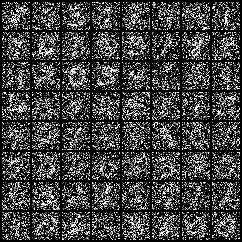

In [30]:
# noise vae generation
sampler = VAE_Sampler()
with torch.no_grad():
    x = sampler.calc(vae_model, 64)
    print(x.shape)
x_vae = x
grid = vutils.make_grid(x_vae, nrow=8)
vutils.save_image(grid, f'samples/gen_ep40_noisevae.png')
display(Image(filename=f'samples/gen_ep40_noisevae.png'))

In [12]:
# cosine schedule
from math import pi
T = 1000
angles = torch.linspace(0.1, pi-0.1, T)
alpha_bars = (1 + torch.cos(angles)) / 2
alphas = torch.ones_like(alpha_bars,dtype=torch.float)
alphas[1:] = alpha_bars[1:] / alpha_bars[:-1]
sigmas = torch.sqrt(1-alphas)
alpha_bars[::100]

tensor([0.9975, 0.9616, 0.8860, 0.7771, 0.6444, 0.4993, 0.3542, 0.2217, 0.1131,
        0.0378])

In [13]:
from vanilla_unet import UNet
model = UNet().cuda()
model = nn.DataParallel(model)
print('model params:', sum(p.numel() for p in model.parameters()))
model.load_state_dict(torch.load('checkpoints/half_ddpm.pth'))

model params: 6065665


/tmp/ipykernel_784437/1010779120.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/half_ddpm.pth'))


<All keys matched successfully>

In [18]:
@torch.no_grad()
def sample_halfddpm(model,x0,num=64,ep=0):
    x = x0
    grid = vutils.make_grid(x, nrow=8)
    vutils.save_image(grid, f'samples/gen_ep_{ep}_halfddpm_init.png')
    
    for t in trange(T//2-1,-1,-1,desc=f'Epoch {ep} sampling'):
        w1 = 1/torch.sqrt(alphas[t]).cuda()
        w2 = (1-alphas[t])/torch.sqrt(1-alpha_bars[t]).cuda()
        x = w1 * (x - w2 * model(x,torch.tensor([t]).cuda().repeat(x.shape[0],))) + sigmas[t].cuda().reshape(-1,1,1,1) * torch.randn_like(x)
    # make grid
    grid = vutils.make_grid(x, nrow=8)
    vutils.save_image(grid, f'samples/gen_ep_{ep}_halfddpm_sample.png')
    return x

Epoch 40 sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.25it/s]


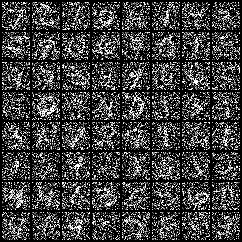

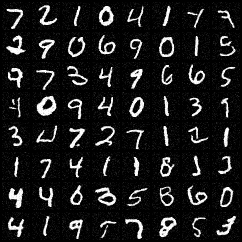

In [19]:
# from test loader
x = next(iter(test_loader))[0][:64].cuda()
noise = torch.randn_like(x)
x0 = (x + noise)/torch.sqrt(torch.tensor(2.))
x = sample_halfddpm(model,x0,num=64,ep=40)
display(Image(filename=f'samples/gen_ep_40_halfddpm_init.png'))
display(Image(filename=f'samples/gen_ep_40_halfddpm_sample.png'))

Epoch with_vae sampling: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.80it/s]


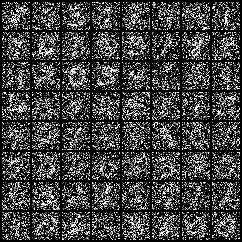

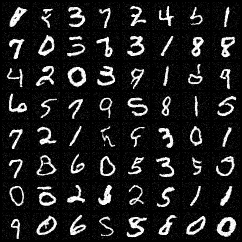

In [31]:
# from test loader
x = sample_halfddpm(model,x_vae,num=64,ep='with_vae')
display(Image(filename=f'samples/gen_ep_with_vae_halfddpm_init.png'))
display(Image(filename=f'samples/gen_ep_with_vae_halfddpm_sample.png'))

In [43]:
y_vae=super(vae_model.__class__, vae_model).decode(torch.randn(64, vae_model.latent_dim).cuda())

In [44]:
y_vae.shape

torch.Size([64, 1, 28, 28])

In [46]:
y_vae.max(),y_vae.min(),y_vae.mean(),y_vae.std()

(tensor(1.0083, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-0.3022, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.0867, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.1637, device='cuda:0', grad_fn=<StdBackward0>))

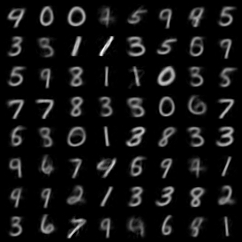

In [47]:
# visualize
grid = vutils.make_grid(y_vae, nrow=8)
vutils.save_image(grid, f'samples/vae.png')
display(Image(filename=f'samples/vae.png'))

y_vae stats: tensor(1.3108, device='cuda:0', grad_fn=<MulBackward0>) tensor(-0.3929, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.1127, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.2129, device='cuda:0', grad_fn=<MulBackward0>)


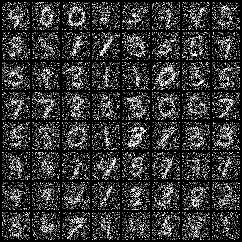

In [57]:
t_big = 300
print('y_vae stats:', y_vae.max()*1.3,y_vae.min()*1.3,y_vae.mean()*1.3,y_vae.std()*1.3)
y_bar = y_vae * 1.3 * alpha_bars[t_big].sqrt() + torch.randn_like(y_vae) * torch.sqrt(1-alpha_bars[t_big])
grid = vutils.make_grid(y_bar, nrow=8)
vutils.save_image(grid, f'samples/vae_bar.png')
display(Image(filename=f'samples/vae_bar.png'))

In [36]:
@torch.no_grad()
def sample_halfddpm_200(model,x0,num=64,ep=0,t_big=200):
    x = x0
    grid = vutils.make_grid(x, nrow=8)
    vutils.save_image(grid, f'samples/gen_ep_{ep}_halfddpm_init.png')
    
    for t in trange(t_big-1,-1,-1,desc=f'Epoch {ep} sampling'):
        w1 = 1/torch.sqrt(alphas[t]).cuda()
        w2 = (1-alphas[t])/torch.sqrt(1-alpha_bars[t]).cuda()
        x = w1 * (x - w2 * model(x,torch.tensor([t]).cuda().repeat(x.shape[0],))) + sigmas[t].cuda().reshape(-1,1,1,1) * torch.randn_like(x)
    # make grid
    grid = vutils.make_grid(x, nrow=8)
    vutils.save_image(grid, f'samples/gen_ep_{ep}_halfddpm_sample.png')
    return x

In [37]:
sample_halfddpm_200(model,y_bar,num=64,ep='vae_200',t_big=200)

Epoch vae_200 sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 50.94it/s]


tensor([[[[ 0.0482,  0.0490,  0.0378,  ..., -0.1179, -0.0112, -0.0020],
          [ 0.0470, -0.0245, -0.0545,  ...,  0.0824,  0.0308,  0.0314],
          [ 0.0074, -0.0619,  0.0754,  ..., -0.0347, -0.0201, -0.0266],
          ...,
          [ 0.0341,  0.0678,  0.0054,  ..., -0.0846,  0.0528, -0.0378],
          [ 0.0526,  0.0489,  0.0477,  ..., -0.0600,  0.0123, -0.0208],
          [ 0.0630, -0.0246,  0.0656,  ..., -0.0522,  0.0199, -0.0476]]],


        [[[-0.1040,  0.0764,  0.0012,  ...,  0.0282, -0.0251, -0.0854],
          [-0.0528,  0.0120, -0.0114,  ...,  0.0596, -0.0295,  0.0406],
          [-0.0578,  0.0428, -0.0471,  ...,  0.0153, -0.0887,  0.0303],
          ...,
          [-0.1012, -0.0011,  0.0314,  ..., -0.0272, -0.0785,  0.0030],
          [ 0.0254, -0.0380, -0.0092,  ...,  0.0293, -0.0248, -0.0658],
          [ 0.0884,  0.0018, -0.0263,  ...,  0.0104, -0.0564,  0.0457]]],


        [[[-0.0895,  0.0097,  0.0054,  ...,  0.0861, -0.0632,  0.0486],
          [-0.0270, -0.082

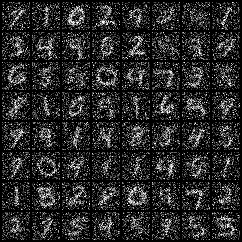

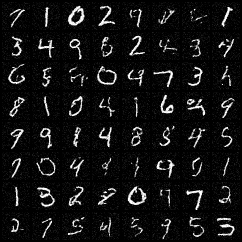

In [38]:
display(Image(filename=f'samples/gen_ep_vae_200_halfddpm_init.png'))
display(Image(filename=f'samples/gen_ep_vae_200_halfddpm_sample.png'))

t_big: 300


Epoch vae_300 sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 50.36it/s]


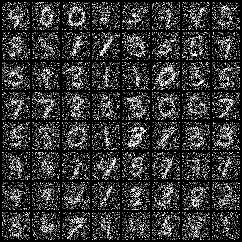

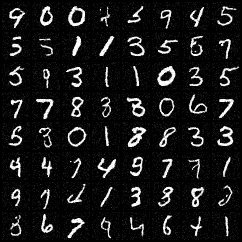

In [58]:
print('t_big:',t_big)
out = sample_halfddpm_200(model,y_bar,num=64,ep=f'vae_{t_big}',t_big=t_big)
display(Image(filename=f'samples/gen_ep_vae_{t_big}_halfddpm_init.png'))
display(Image(filename=f'samples/gen_ep_vae_{t_big}_halfddpm_sample.png'))

In [59]:
out.max(),out.min(),out.mean(),out.std()

(tensor(1.2150, device='cuda:0'),
 tensor(-0.2158, device='cuda:0'),
 tensor(0.1032, device='cuda:0'),
 tensor(0.2764, device='cuda:0'))

In [ ]:
datapoints = next(iter(test_loader))[0][:64]
# visualize
grid = vutils.make_grid(datapoints, nrow=8)
vutils.save_image(grid, f'samples/datapoints.png')
display(Image(filename=f'samples/datapoints.png'))

In [52]:
datapoints.max(),datapoints.min(),datapoints.mean(),datapoints.std()

(tensor(1.), tensor(0.), tensor(0.1147), tensor(0.2892))

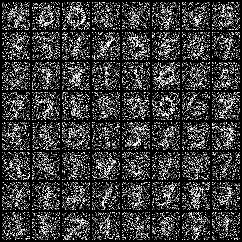

t_big: 400


Epoch vae_400 sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.89it/s]


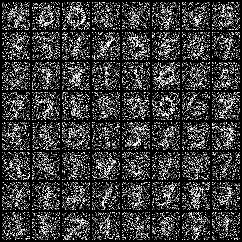

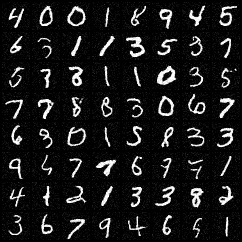

In [60]:
t_big = 400
y_bar = y_vae * 1.3 * alpha_bars[t_big].sqrt() + torch.randn_like(y_vae) * torch.sqrt(1-alpha_bars[t_big])
grid = vutils.make_grid(y_bar, nrow=8)
vutils.save_image(grid, f'samples/vae_bar.png')
display(Image(filename=f'samples/vae_bar.png'))
print('t_big:',t_big)
out = sample_halfddpm_200(model,y_bar,num=64,ep=f'vae_{t_big}',t_big=t_big)
display(Image(filename=f'samples/gen_ep_vae_{t_big}_halfddpm_init.png'))
display(Image(filename=f'samples/gen_ep_vae_{t_big}_halfddpm_sample.png'))